# Your First RAG Application

In this notebook, we'll walk you through each of the components that are involved in a simple RAG application.

We won't be leveraging any fancy tools, just the OpenAI Python SDK, Numpy, and some classic Python.

> NOTE: This was done with Python 3.12.3.

> NOTE: There might be [compatibility issues](https://github.com/wandb/wandb/issues/7683) if you're on NVIDIA driver >552.44 As an interim solution - you can rollback your drivers to the 552.44.

## Table of Contents:

- Task 1: Imports and Utilities
- Task 2: Documents
- Task 3: Embeddings and Vectors
- Task 4: Prompts
- Task 5: Retrieval Augmented Generation
  - 🚧 Activity #1: Augment RAG

Let's look at a rather complicated looking visual representation of a basic RAG application.

<img src="https://i.imgur.com/vD8b016.png" />

## Task 1: Imports and Utility

We're just doing some imports and enabling `async` to work within the Jupyter environment here, nothing too crazy!

In [23]:
from aimakerspace.text_utils import TextFileLoader, CharacterTextSplitter
from aimakerspace.vectordatabase import VectorDatabase
import asyncio

In [24]:
import nest_asyncio
nest_asyncio.apply()

## Task 2: Documents

We'll be concerning ourselves with this part of the flow in the following section:

<img src="https://i.imgur.com/jTm9gjk.png" />

### Loading Source Documents

So, first things first, we need some documents to work with.

While we could work directly with the `.txt` files (or whatever file-types you wanted to extend this to) we can instead do some batch processing of those documents at the beginning in order to store them in a more machine compatible format.

In this case, we're going to parse our text file into a single document in memory.

Let's look at the relevant bits of the `TextFileLoader` class:

```python
def load_file(self):
        with open(self.path, "r", encoding=self.encoding) as f:
            self.documents.append(f.read())
```

We're simply loading the document using the built in `open` method, and storing that output in our `self.documents` list.

> NOTE: We're using blogs from PMarca (Marc Andreessen) as our sample data. This data is largely irrelevant as we want to focus on the mechanisms of RAG, which includes out data's shape and quality - but not specifically what the contents of the data are. 


In [25]:
text_loader = TextFileLoader("data/PMarcaBlogs.txt")
documents = text_loader.load_documents()
len(documents)

1

In [26]:
print(documents[0][:100])


The Pmarca Blog Archives
(select posts from 2007-2009)
Marc Andreessen
copyright: Andreessen Horow


### Splitting Text Into Chunks

As we can see, there is one massive document.

We'll want to chunk the document into smaller parts so it's easier to pass the most relevant snippets to the LLM.

There is no fixed way to split/chunk documents - and you'll need to rely on some intuition as well as knowing your data *very* well in order to build the most robust system.

For this toy example, we'll just split blindly on length.

>There's an opportunity to clear up some terminology here, for this course we will be stick to the following:
>
>- "source documents" : The `.txt`, `.pdf`, `.html`, ..., files that make up the files and information we start with in its raw format
>- "document(s)" : single (or more) text object(s)
>- "corpus" : the combination of all of our documents

As you can imagine (though it's not specifically true in this toy example) the idea of splitting documents is to break them into managable sized chunks that retain the most relevant local context.

In [27]:
text_splitter = CharacterTextSplitter()
split_documents = text_splitter.split_texts(documents)
len(split_documents)

373

Let's take a look at some of the documents we've managed to split.

In [28]:
split_documents[0:1]

['\ufeff\nThe Pmarca Blog Archives\n(select posts from 2007-2009)\nMarc Andreessen\ncopyright: Andreessen Horowitz\ncover design: Jessica Hagy\nproduced using: Pressbooks\nContents\nTHE PMARCA GUIDE TO STARTUPS\nPart 1: Why not to do a startup 2\nPart 2: When the VCs say "no" 10\nPart 3: "But I don\'t know any VCs!" 18\nPart 4: The only thing that matters 25\nPart 5: The Moby Dick theory of big companies 33\nPart 6: How much funding is too little? Too much? 41\nPart 7: Why a startup\'s initial business plan doesn\'t\nmatter that much\n49\nTHE PMARCA GUIDE TO HIRING\nPart 8: Hiring, managing, promoting, and Dring\nexecutives\n54\nPart 9: How to hire a professional CEO 68\nHow to hire the best people you\'ve ever worked\nwith\n69\nTHE PMARCA GUIDE TO BIG COMPANIES\nPart 1: Turnaround! 82\nPart 2: Retaining great people 86\nTHE PMARCA GUIDE TO CAREER, PRODUCTIVITY,\nAND SOME OTHER THINGS\nIntroduction 97\nPart 1: Opportunity 99\nPart 2: Skills and education 107\nPart 3: Where to go and wh

## Task 3: Embeddings and Vectors

Next, we have to convert our corpus into a "machine readable" format as we explored in the Embedding Primer notebook.

Today, we're going to talk about the actual process of creating, and then storing, these embeddings, and how we can leverage that to intelligently add context to our queries.

### OpenAI API Key

In order to access OpenAI's APIs, we'll need to provide our OpenAI API Key!

You can work through the folder "OpenAI API Key Setup" for more information on this process if you don't already have an API Key!

In [29]:
import os
import openai
from getpass import getpass

openai.api_key = getpass("OpenAI API Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key

### Vector Database

Let's set up our vector database to hold all our documents and their embeddings!

While this is all baked into 1 call - we can look at some of the code that powers this process to get a better understanding:

Let's look at our `VectorDatabase().__init__()`:

```python
def __init__(self, embedding_model: EmbeddingModel = None):
        self.vectors = defaultdict(np.array)
        self.embedding_model = embedding_model or EmbeddingModel()
```

As you can see - our vectors are merely stored as a dictionary of `np.array` objects.

Secondly, our `VectorDatabase()` has a default `EmbeddingModel()` which is a wrapper for OpenAI's `text-embedding-3-small` model.

> **Quick Info About `text-embedding-3-small`**:
> - It has a context window of **8191** tokens
> - It returns vectors with dimension **1536**

#### ❓Question #1:

The default embedding dimension of `text-embedding-3-small` is 1536, as noted above. 

1. Is there any way to modify this dimension?
2. What technique does OpenAI use to achieve this?

> NOTE: Check out this [API documentation](https://platform.openai.com/docs/api-reference/embeddings/create) for the answer to question #1.1, and [this documentation](https://platform.openai.com/docs/guides/embeddings/use-cases) for an answer to question #1.2!


##### ✅ Answer:
1. Yes, via the API request body parameter "dimensions <integer>"
2. OpenAI achieves this by leveraging Matryoshka Representation Learning (MRL) which "encodes information at different granularities and allows a single embedding to adapt to the computational constraints of downstream tasks". (https://arxiv.org/abs/2205.13147)

We can call the `async_get_embeddings` method of our `EmbeddingModel()` on a list of `str` and receive a list of `float` back!

```python
async def async_get_embeddings(self, list_of_text: List[str]) -> List[List[float]]:
        return await aget_embeddings(
            list_of_text=list_of_text, engine=self.embeddings_model_name
        )
```

We cast those to `np.array` when we build our `VectorDatabase()`:

```python
async def abuild_from_list(self, list_of_text: List[str]) -> "VectorDatabase":
        embeddings = await self.embedding_model.async_get_embeddings(list_of_text)
        for text, embedding in zip(list_of_text, embeddings):
            self.insert(text, np.array(embedding))
        return self
```

And that's all we need to do!

In [30]:
vector_db = VectorDatabase()
vector_db = asyncio.run(vector_db.abuild_from_list(split_documents))

#### ❓Question #2:

What are the benefits of using an `async` approach to collecting our embeddings?

> NOTE: Determining the core difference between `async` and `sync` will be useful! If you get stuck - ask ChatGPT!

##### ✅ Answer: The benefits are performance, resource utilization and scale. Since a corpus of documents would require multiple API calls and db i/o streams, it makes sense to execute them in parallel for perfromance.


So, to review what we've done so far in natural language:

1. We load source documents
2. We split those source documents into smaller chunks (documents)
3. We send each of those documents to the `text-embedding-3-small` OpenAI API endpoint
4. We store each of the text representations with the vector representations as keys/values in a dictionary

### Semantic Similarity

The next step is to be able to query our `VectorDatabase()` with a `str` and have it return to us vectors and text that is most relevant from our corpus.

We're going to use the following process to achieve this in our toy example:

1. We need to embed our query with the same `EmbeddingModel()` as we used to construct our `VectorDatabase()`
2. We loop through every vector in our `VectorDatabase()` and use a distance measure to compare how related they are
3. We return a list of the top `k` closest vectors, with their text representations

There's some very heavy optimization that can be done at each of these steps - but let's just focus on the basic pattern in this notebook.

> We are using [cosine similarity](https://www.engati.com/glossary/cosine-similarity) as a distance metric in this example - but there are many many distance metrics you could use - like [these](https://flavien-vidal.medium.com/similarity-distances-for-natural-language-processing-16f63cd5ba55)

> We are using a rather inefficient way of calculating relative distance between the query vector and all other vectors - there are more advanced approaches that are much more efficient, like [ANN](https://towardsdatascience.com/comprehensive-guide-to-approximate-nearest-neighbors-algorithms-8b94f057d6b6)

In [31]:
vector_db.search_by_text("What is the Michael Eisner Memorial Weak Executive Problem?", k=3)

[('ordingly.\nSeventh, when hiring the executive to run your former specialty, be\ncareful you don’t hire someone weak on purpose.\nThis sounds silly, but you wouldn’t believe how oaen it happens.\nThe CEO who used to be a product manager who has a weak\nproduct management executive. The CEO who used to be in\nsales who has a weak sales executive. The CEO who used to be\nin marketing who has a weak marketing executive.\nI call this the “Michael Eisner Memorial Weak Executive Problem” — aaer the CEO of Disney who had previously been a brilliant TV network executive. When he bought ABC at Disney, it\npromptly fell to fourth place. His response? “If I had an extra\ntwo days a week, I could turn around ABC myself.” Well, guess\nwhat, he didn’t have an extra two days a week.\nA CEO — or a startup founder — oaen has a hard time letting\ngo of the function that brought him to the party. The result: you\nhire someone weak into the executive role for that function so\nthat you can continue to b

## Task 4: Prompts

In the following section, we'll be looking at the role of prompts - and how they help us to guide our application in the right direction.

In this notebook, we're going to rely on the idea of "zero-shot in-context learning".

This is a lot of words to say: "We will ask it to perform our desired task in the prompt, and provide no examples."

### XYZRolePrompt

Before we do that, let's stop and think a bit about how OpenAI's chat models work.

We know they have roles - as is indicated in the following API [documentation](https://platform.openai.com/docs/api-reference/chat/create#chat/create-messages)

There are three roles, and they function as follows (taken directly from [OpenAI](https://platform.openai.com/docs/guides/gpt/chat-completions-api)):

- `{"role" : "system"}` : The system message helps set the behavior of the assistant. For example, you can modify the personality of the assistant or provide specific instructions about how it should behave throughout the conversation. However note that the system message is optional and the model’s behavior without a system message is likely to be similar to using a generic message such as "You are a helpful assistant."
- `{"role" : "user"}` : The user messages provide requests or comments for the assistant to respond to.
- `{"role" : "assistant"}` : Assistant messages store previous assistant responses, but can also be written by you to give examples of desired behavior.

The main idea is this:

1. You start with a system message that outlines how the LLM should respond, what kind of behaviours you can expect from it, and more
2. Then, you can provide a few examples in the form of "assistant"/"user" pairs
3. Then, you prompt the model with the true "user" message.

In this example, we'll be forgoing the 2nd step for simplicities sake.

#### Utility Functions

You'll notice that we're using some utility functions from the `aimakerspace` module - let's take a peek at these and see what they're doing!

##### XYZRolePrompt

Here we have our `system`, `user`, and `assistant` role prompts.

Let's take a peek at what they look like:

```python
class BasePrompt:
    def __init__(self, prompt):
        """
        Initializes the BasePrompt object with a prompt template.

        :param prompt: A string that can contain placeholders within curly braces
        """
        self.prompt = prompt
        self._pattern = re.compile(r"\{([^}]+)\}")

    def format_prompt(self, **kwargs):
        """
        Formats the prompt string using the keyword arguments provided.

        :param kwargs: The values to substitute into the prompt string
        :return: The formatted prompt string
        """
        matches = self._pattern.findall(self.prompt)
        return self.prompt.format(**{match: kwargs.get(match, "") for match in matches})

    def get_input_variables(self):
        """
        Gets the list of input variable names from the prompt string.

        :return: List of input variable names
        """
        return self._pattern.findall(self.prompt)
```

Then we have our `RolePrompt` which laser focuses us on the role pattern found in most API endpoints for LLMs.

```python
class RolePrompt(BasePrompt):
    def __init__(self, prompt, role: str):
        """
        Initializes the RolePrompt object with a prompt template and a role.

        :param prompt: A string that can contain placeholders within curly braces
        :param role: The role for the message ('system', 'user', or 'assistant')
        """
        super().__init__(prompt)
        self.role = role

    def create_message(self, **kwargs):
        """
        Creates a message dictionary with a role and a formatted message.

        :param kwargs: The values to substitute into the prompt string
        :return: Dictionary containing the role and the formatted message
        """
        return {"role": self.role, "content": self.format_prompt(**kwargs)}
```

We'll look at how the `SystemRolePrompt` is constructed to get a better idea of how that extension works:

```python
class SystemRolePrompt(RolePrompt):
    def __init__(self, prompt: str):
        super().__init__(prompt, "system")
```

That pattern is repeated for our `UserRolePrompt` and our `AssistantRolePrompt` as well.

##### ChatOpenAI

Next we have our model, which is converted to a format analagous to libraries like LangChain and LlamaIndex.

Let's take a peek at how that is constructed:

```python
class ChatOpenAI:
    def __init__(self, model_name: str = "gpt-4.1-mini"):
        self.model_name = model_name
        self.openai_api_key = os.getenv("OPENAI_API_KEY")
        if self.openai_api_key is None:
            raise ValueError("OPENAI_API_KEY is not set")

    def run(self, messages, text_only: bool = True):
        if not isinstance(messages, list):
            raise ValueError("messages must be a list")

        openai.api_key = self.openai_api_key
        response = openai.ChatCompletion.create(
            model=self.model_name, messages=messages
        )

        if text_only:
            return response.choices[0].message.content

        return response
```

#### ❓ Question #3:

When calling the OpenAI API - are there any ways we can achieve more reproducible outputs?

> NOTE: Check out [this section](https://platform.openai.com/docs/guides/text-generation/) of the OpenAI documentation for the answer!

##### ✅ Answer: From the documentation above, "Reusable Prompts" wolud allow you to ensure consistent prompts and parameters which would help achieve more reproducible outputs. There are other parameters like seed and temperature that can enhance reproducibility as well.


### Creating and Prompting OpenAI's `gpt-4.1-mini`!

Let's tie all these together and use it to prompt `gpt-4.1-mini`!

In [32]:
from aimakerspace.openai_utils.prompts import (
    UserRolePrompt,
    SystemRolePrompt,
    AssistantRolePrompt,
)

from aimakerspace.openai_utils.chatmodel import ChatOpenAI

chat_openai = ChatOpenAI()
user_prompt_template = "{content}"
user_role_prompt = UserRolePrompt(user_prompt_template)
system_prompt_template = (
    "You are an expert in {expertise}, you always answer in a kind way."
)
system_role_prompt = SystemRolePrompt(system_prompt_template)

messages = [
    system_role_prompt.create_message(expertise="Python"),
    user_role_prompt.create_message(
        content="What is the best way to write a loop?"
    ),
]

response = chat_openai.run(messages)

In [33]:
print(response)

Hello! The best way to write a loop in Python depends on what you want to accomplish, but generally, the most common and Pythonic way is using a `for` loop when you want to iterate over a sequence (like a list, tuple, string, or range).

Here's a basic example of a `for` loop in Python:

```python
for i in range(5):
    print(i)
```

This will print numbers from 0 to 4.

If you want to repeat an action while a condition is true, a `while` loop is appropriate:

```python
count = 0
while count < 5:
    print(count)
    count += 1
```

In Python, using `for` loops with iterables is usually preferred because it's clearer and less error-prone.

If you have a specific task in mind, I’d be happy to help you write the most effective loop for it!


## Task 5: Retrieval Augmented Generation

Now we can create a RAG prompt - which will help our system behave in a way that makes sense!

There is much you could do here, many tweaks and improvements to be made!

In [34]:
RAG_SYSTEM_TEMPLATE = """You are a knowledgeable assistant that answers questions based strictly on provided context.

Instructions:
- Only answer questions using information from the provided context
- If the context doesn't contain relevant information, respond with "I don't know"
- Be accurate and cite specific parts of the context when possible
- Keep responses {response_style} and {response_length}
- Only use the provided context. Do not use external knowledge.
- Only provide answers when you are confident the context supports your response."""

RAG_USER_TEMPLATE = """Context Information:
{context}

Number of relevant sources found: {context_count}
{similarity_scores}

Question: {user_query}

Please provide your answer based solely on the context above."""

rag_system_prompt = SystemRolePrompt(
    RAG_SYSTEM_TEMPLATE,
    strict=True,
    defaults={
        "response_style": "concise",
        "response_length": "brief"
    }
)

rag_user_prompt = UserRolePrompt(
    RAG_USER_TEMPLATE,
    strict=True,
    defaults={
        "context_count": "",
        "similarity_scores": ""
    }
)

Now we can create our pipeline!

In [37]:
class RetrievalAugmentedQAPipeline:
    def __init__(self, llm: ChatOpenAI, vector_db_retriever: VectorDatabase, 
                 response_style: str = "detailed", include_scores: bool = False) -> None:
        self.llm = llm
        self.vector_db_retriever = vector_db_retriever
        self.response_style = response_style
        self.include_scores = include_scores

    def run_pipeline(self, user_query: str, k: int = 4, **system_kwargs) -> dict:
        # Retrieve relevant contexts
        context_list = self.vector_db_retriever.search_by_text(user_query, k=k)
        
        context_prompt = ""
        similarity_scores = []
        
        for i, (context, score) in enumerate(context_list, 1):
            context_prompt += f"[Source {i}]: {context}\n\n"
            similarity_scores.append(f"Source {i}: {score:.3f}")
        
        # Create system message with parameters
        system_params = {
            "response_style": self.response_style,
            "response_length": system_kwargs.get("response_length", "detailed")
        }
        
        formatted_system_prompt = rag_system_prompt.create_message(**system_params)
        
        user_params = {
            "user_query": user_query,
            "context": context_prompt.strip(),
            "context_count": len(context_list),
            "similarity_scores": f"Relevance scores: {', '.join(similarity_scores)}" if self.include_scores else ""
        }
        
        formatted_user_prompt = rag_user_prompt.create_message(**user_params)

        return {
            "response": self.llm.run([formatted_system_prompt, formatted_user_prompt]), 
            "context": context_list,
            "context_count": len(context_list),
            "similarity_scores": similarity_scores if self.include_scores else None,
            "prompts_used": {
                "system": formatted_system_prompt,
                "user": formatted_user_prompt
            }
        }

In [38]:
rag_pipeline = RetrievalAugmentedQAPipeline(
    vector_db_retriever=vector_db,
    llm=chat_openai,
    response_style="detailed",
    include_scores=True
)

result = rag_pipeline.run_pipeline(
    "What is the 'Michael Eisner Memorial Weak Executive Problem'?",
    k=3,
    response_length="comprehensive", 
    include_warnings=True,
    confidence_required=True
)

print(f"Response: {result['response']}")
print(f"\nContext Count: {result['context_count']}")
print(f"Similarity Scores: {result['similarity_scores']}")

Response: The "Michael Eisner Memorial Weak Executive Problem" refers to a situation where a CEO hires a weak executive to run the function that the CEO themselves used to manage, often because the CEO has a hard time letting go of the function that brought them to the company. For example, a CEO who was formerly a product manager might hire a weak product management executive; a CEO formerly in sales might hire a weak sales executive; and similarly for marketing. This leads to weakened leadership in that function because the CEO retains control or influence by hiring someone less capable. The term is named after Michael Eisner, the CEO of Disney, who was a brilliant TV network executive but when he bought ABC at Disney, ABC fell to fourth place. Eisner claimed he could have turned ABC around himself if he had extra time, but he did not, illustrating the problem of trying to maintain control over a function by not hiring a strong executive for it (Source 1).

Context Count: 3
Similarit

#### ❓ Question #4:

What prompting strategies could you use to make the LLM have a more thoughtful, detailed response?

What is that strategy called?

> NOTE: You can look through our [OpenAI Responses API](https://colab.research.google.com/drive/14SCfRnp39N7aoOx8ZxadWb0hAqk4lQdL?usp=sharing) notebook for an answer to this question if you get stuck!

##### ✅ Answer: Leverage developer (system) instructions to guide the model's behavior. A specific strategy for a more thoughtful detailed response is "Chain-of-Thought (CoT)" prompting. This prompt instructs the model in the prompt to "think step by step" or perform an action "step by step".


### 🏗️ Activity #1:

Enhance your RAG application in some way! 

Suggestions are: 

- Allow it to work with PDF files
- Implement a new distance metric
- Add metadata support to the vector database
- Use a different embedding model
- Add the capability to ingest a YouTube link

While these are suggestions, you should feel free to make whatever augmentations you desire! If you shared an idea during Session 1, think about features you might need to incorporate for your use case! 

When you're finished making the augments to your RAG application - vibe check it against the old one - see if you can "feel the improvement"!

> NOTE: These additions might require you to work within the `aimakerspace` library - that's expected!

> NOTE: If you're not sure where to start - ask Cursor (CMD/CTRL+L) to guide you through the changes!

## Enhanced RAG with PDF Support

In this section, we'll enhance our RAG application to support PDF document ingestion alongside text files. We've added new classes to the `aimakerspace.text_utils` module:

- `PDFFileLoader`: Specifically handles PDF files using PyPDF2
- `UniversalDocumentLoader`: A unified loader that can handle both text and PDF files

We will demonstrate this enhanced functionality using the `Principles_of_Management.pdf` file in the /data directory.


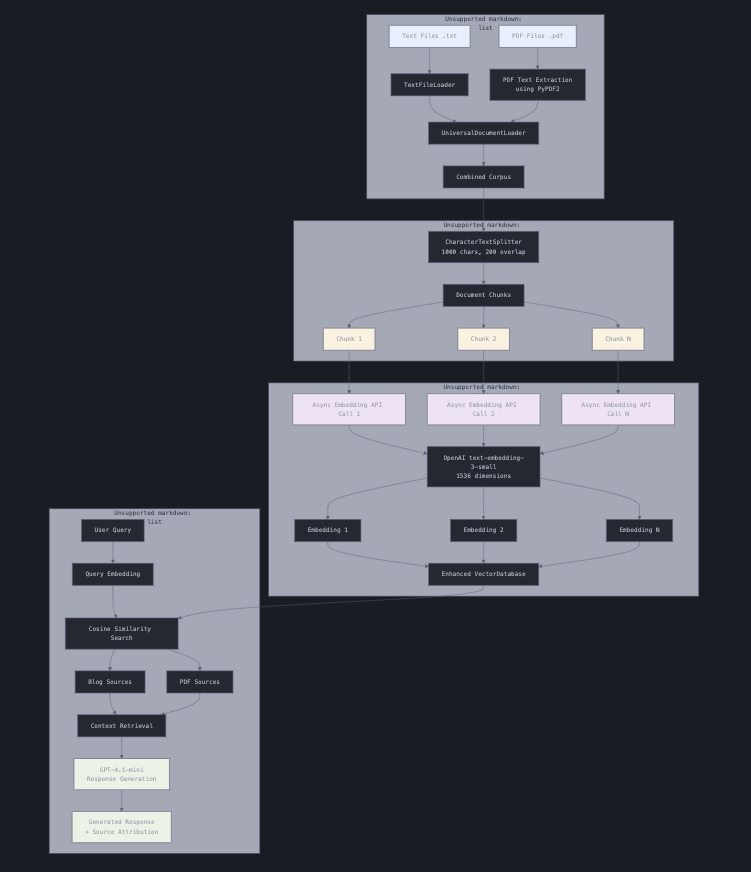

✅ Displaying: images/new_rag.jpg


In [50]:
# Display the enhanced RAG architecture diagram
from IPython.display import Image, display
import os

# Check if image exists and display it
image_path = "images/new_rag.jpg"
if os.path.exists(image_path):
    display(Image(filename=image_path))
    print(f"✅ Displaying: {image_path}")
else:
    print(f"❌ Image not found: {image_path}")
    print("Available images:")
    if os.path.exists("images"):
        for img in os.listdir("images"):
            print(f"  - {img}")


In [39]:
# Import all necessary classes for enhanced RAG
from aimakerspace.text_utils import TextFileLoader, PDFFileLoader, UniversalDocumentLoader, CharacterTextSplitter
from aimakerspace.vectordatabase import VectorDatabase
from aimakerspace.openai_utils.chatmodel import ChatOpenAI
from aimakerspace.openai_utils.prompts import UserRolePrompt, SystemRolePrompt
import os
import asyncio

print("✅ All imports loaded successfully for enhanced RAG!")


✅ All imports loaded successfully for enhanced RAG!


In [40]:
# Set up OpenAI API key for enhanced RAG
import openai
from getpass import getpass

# Check if API key is already set in environment
if not os.getenv("OPENAI_API_KEY"):
    openai.api_key = getpass("OpenAI API Key: ")
    os.environ["OPENAI_API_KEY"] = openai.api_key
    print("✅ OpenAI API key set successfully!")
else:
    print("✅ OpenAI API key already available in environment!")


✅ OpenAI API key already available in environment!


### Step 1: Import Enhanced Text Utilities

Import our new PDF-capable loaders:


In [41]:
from aimakerspace.text_utils import PDFFileLoader, UniversalDocumentLoader
import os

# Check if our PDF file exists
pdf_path = "data/Principles_of_Management.pdf"
print(f"PDF file exists: {os.path.exists(pdf_path)}")
print(f"PDF file size: {os.path.getsize(pdf_path) / 1024 / 1024:.2f} MB" if os.path.exists(pdf_path) else "File not found")


PDF file exists: True
PDF file size: 47.85 MB


### Step 2: Load PDF Document

Extract text from the PDF using our new PDFFileLoader:


In [42]:
# Load the PDF document
pdf_loader = PDFFileLoader(pdf_path)
pdf_documents = pdf_loader.load_documents()

print(f"Number of PDF documents loaded: {len(pdf_documents)}")
print(f"Length of PDF text: {len(pdf_documents[0])} characters")
print(f"First 500 characters of PDF:")
print("-" * 50)
print(pdf_documents[0][:500])


Number of PDF documents loaded: 1
Length of PDF text: 1936336 characters
First 500 characters of PDF:
--------------------------------------------------
Princip les of 
Management  

OpenStax  
Rice University  
6100 Main Street MS -375 
Houston, Texas 77005  
To learn more about OpenStax, visit http s://openstax.org.  
Individual print copies and bulk orders can be purchased through our website.  
©2019 Rice University.  Textbook content produced by OpenStax is licensed under a Creative Commons 
Attribution 4.0 International License  (CC BY 4.0) . Under this license, any user of this textb ook or the textbook 
contents herein must provide prope


### Step 3: Create Combined Corpus

Combine both the original blog text and the PDF content using our UniversalDocumentLoader:


In [43]:
# Load all documents from the data directory (both text and PDF)
universal_loader = UniversalDocumentLoader("data")
all_documents = universal_loader.load_documents()

print(f"Total documents loaded: {len(all_documents)}")
print(f"Document types:")
for i, doc in enumerate(all_documents):
    doc_length = len(doc)
    # Heuristic to identify document type based on content
    if "Pmarca Blog" in doc[:200]:
        doc_type = "Blog Archive"
    elif any(word in doc[:500].lower() for word in ["management", "principle", "organization"]):
        doc_type = "Management PDF"
    else:
        doc_type = "Unknown"
    print(f"  Document {i+1}: {doc_type} ({doc_length:,} characters)")


Total documents loaded: 2
Document types:
  Document 1: Management PDF (1,936,336 characters)
  Document 2: Blog Archive (297,904 characters)


### Step 4: Split Combined Documents

Split all documents into chunks for our enhanced vector database:


In [44]:
# First, let's recreate the original split_documents for comparison
# Load only the original blog text
original_text_loader = TextFileLoader("data/PMarcaBlogs.txt")
original_documents = original_text_loader.load_documents()
original_text_splitter = CharacterTextSplitter()
split_documents = original_text_splitter.split_texts(original_documents)

# Now split the combined documents into chunks
enhanced_text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
enhanced_split_documents = enhanced_text_splitter.split_texts(all_documents)

print(f"Number of chunks from enhanced corpus: {len(enhanced_split_documents)}")
print(f"Original corpus had: {len(split_documents)} chunks")
print(f"Enhancement added: {len(enhanced_split_documents) - len(split_documents)} additional chunks")

# Show a sample chunk from the PDF content
pdf_chunks = [chunk for chunk in enhanced_split_documents if any(word in chunk.lower() for word in ["management", "principle", "organization", "planning"])]
if pdf_chunks:
    print(f"\nSample PDF chunk:")
    print("-" * 50)
    print(pdf_chunks[0][:300] + "...")


Number of chunks from enhanced corpus: 2794
Original corpus had: 373 chunks
Enhancement added: 2421 additional chunks

Sample PDF chunk:
--------------------------------------------------
Princip les of 
Management  

OpenStax  
Rice University  
6100 Main Street MS -375 
Houston, Texas 77005  
To learn more about OpenStax, visit http s://openstax.org.  
Individual print copies and bulk orders can be purchased through our website.  
©2019 Rice University.  Textbook content produced b...


### Step 5: Build Enhanced Vector Database

Let's create a new vector database with our enhanced corpus including PDF content:


In [45]:
# Create enhanced vector database with combined content
print("Building enhanced vector database with PDF content...")
enhanced_vector_db = VectorDatabase()
enhanced_vector_db = await enhanced_vector_db.abuild_from_list(enhanced_split_documents)

print(f"Enhanced vector database built with {len(enhanced_vector_db.vectors)} vectors")

# Test semantic search on management topics
management_results = enhanced_vector_db.search_by_text("What are the key principles of effective management?", k=3)
print(f"\nSemantic search results for management question:")
for i, (text, score) in enumerate(management_results, 1):
    print(f"\nResult {i} (similarity: {score:.3f}):")
    print(f"{text[:200]}...")


Building enhanced vector database with PDF content...
Enhanced vector database built with 2794 vectors

Semantic search results for management question:

Result 1 (similarity: 0.568):
 successful managers at a variety of organizational levels to achieve and exceed
objectives effectively and efficiently throughout their careers? Management is a broad business discipline, and
the Pri...

Result 2 (similarity: 0.561):
on must decide issues fairly and equitably. In this way, managers could limit the
ways in which their biases and personal feelings could influence their decisions.
Taken as a whole, Fayol's ideas beca...

Result 3 (similarity: 0.538):
ion
6. Subordination of Individual Interest
7. Remuneration
8. Centralization
9. Scalar Chain
10. Order
11. Equity
12. Stability of Tenure of Personnel
13. Initiative—Employees should be given the nec...


### Step 6: Enhanced RAG Pipeline

Let's create an enhanced RAG pipeline that can answer questions from both the blog content and the management PDF:


In [46]:
# Create enhanced RAG pipeline
enhanced_rag_pipeline = RetrievalAugmentedQAPipeline(
    vector_db_retriever=enhanced_vector_db,
    llm=chat_openai,
    response_style="detailed",
    include_scores=True
)

print("Enhanced RAG Pipeline created successfully!")
print(f"Database contains {len(enhanced_vector_db.vectors)} text chunks from multiple sources")


Enhanced RAG Pipeline created successfully!
Database contains 2794 text chunks from multiple sources


### Step 7: Test Enhanced RAG with Management Questions

Let's test our enhanced RAG system with questions about management principles:


In [47]:
# Test with management-related questions
management_question = "What are the key functions of management and how do they relate to organizational success?"

result = enhanced_rag_pipeline.run_pipeline(
    management_question,
    k=4,
    response_length="comprehensive"
)

print(f"Question: {management_question}")
print(f"\nResponse: {result['response']}")
print(f"\nContext Count: {result['context_count']}")
print(f"Similarity Scores: {result['similarity_scores']}")

print(f"\nSource contexts used:")
for i, (context, score) in enumerate(result['context'], 1):
    print(f"\nSource {i} (score: {score:.3f}):")
    print(f"{context[:150]}...")
    # Try to identify if this is from blog or PDF
    source_type = "Management PDF" if any(word in context.lower() for word in ["management", "principle", "planning", "organization"]) else "Blog Archive"
    print(f"Likely source: {source_type}")


Question: What are the key functions of management and how do they relate to organizational success?

Response: Based on the provided context, the key functions of management that relate to organizational success include:

1. **Communication with Direct Reports**: One of the most important functions managers perform is communicating with their direct reports. This communication helps the organization achieve and exceed its goals (Source 1). Effective communication ensures alignment of objectives and facilitates coordination among employees.

2. **Managing Learning and Knowledge Processes**: Organizations must develop the ability to manage learning and knowledge processes to be successful. This involves systems to collect data, analyze it into information, and use that information to gain knowledge and insight. Organizational learning is the acquisition of knowledge through this cycle, which is critical for adapting and innovating (Source 4).

3. **Leadership and Creative Thinking**: In

### Step 8: Compare Original vs Enhanced RAG

Let's compare how the original RAG (blog-only) performs versus our enhanced RAG (blog + PDF) on the same question:


In [48]:
# Test the same question with original RAG (blog-only)
test_question = "What are effective leadership strategies?"

print("=" * 80)
print("COMPARISON: Original RAG vs Enhanced RAG")
print("=" * 80)

print("\n📚 ORIGINAL RAG (Blog content only):")
original_result = rag_pipeline.run_pipeline(test_question, k=3)
print(f"Response: {original_result['response']}")

print(f"\n📖 ENHANCED RAG (Blog + PDF content):")
enhanced_result = enhanced_rag_pipeline.run_pipeline(test_question, k=3)
print(f"Response: {enhanced_result['response']}")

print(f"\n🔍 ANALYSIS:")
print(f"Original sources found: {original_result['context_count']}")
print(f"Enhanced sources found: {enhanced_result['context_count']}")
print(f"Enhanced response length: {len(enhanced_result['response'])} vs Original: {len(original_result['response'])} characters")


COMPARISON: Original RAG vs Enhanced RAG

📚 ORIGINAL RAG (Blog content only):
Response: Effective leadership strategies based on the provided context include:

1. **Promoting Top Talent Quickly and Clearly**: Identify your top 20 or 30 up-and-coming managers who are strong, sharp, aggressive, and ambitious, and promote them rapidly to director- or VP-level roles. Give them sole charge of clearly identified teams and missions along with substantial option packages. This reduces unnecessary layers of management, ensuring that as CEO, you have at most one executive between you and these key players. Failure to do this or having multiple layers in between is likely to lead to failure (Source 1).

2. **Establish Clear Accountability for Critical Objectives**: Determine the single most important thing your company needs to win at and appoint your best person to lead that effort, focusing the organization's energy on critical missions (Source 1).

3. **Slyly Gather Data Across All Levels**: L

### Step 9: Test Cross-Domain Questions

Let's test questions that might benefit from having both business blog insights and formal management theory:


In [49]:
# Test questions that benefit from both sources
cross_domain_questions = [
    "How do startup principles relate to traditional management theory?",
    "What are the differences between entrepreneurial leadership and corporate management?",
    "How can traditional management principles be applied in tech startups?"
]

for i, question in enumerate(cross_domain_questions, 1):
    print(f"\n{'='*60}")
    print(f"CROSS-DOMAIN QUESTION {i}: {question}")
    print('='*60)
    
    result = enhanced_rag_pipeline.run_pipeline(question, k=4)
    print(f"\nResponse: {result['response']}")
    
    # Analyze source diversity
    blog_sources = sum(1 for context, _ in result['context'] if not any(word in context.lower() for word in ["management", "principle", "planning", "organization"]))
    pdf_sources = result['context_count'] - blog_sources
    
    print(f"\nSource Analysis:")
    print(f"  • Blog sources: {blog_sources}")
    print(f"  • PDF sources: {pdf_sources}")
    print(f"  • Source diversity: {'High' if blog_sources > 0 and pdf_sources > 0 else 'Low'}")



CROSS-DOMAIN QUESTION 1: How do startup principles relate to traditional management theory?

Response: Based on the provided context, the relationship between startup principles and traditional management theory can be understood through the distinction in leadership and team dynamics typical of startups versus established firms.

From Source 1 and Source 4, it is clear that startups have highly variable outcomes in terms of success, largely influenced by the quality and interplay of three core elements: team, product, and market. Startups often form their initial teams from trusted relationships such as family, friends, or former colleagues, which poses unique challenges in managing team dynamics effectively — specifically managing relationships, roles, and rewards (Source 4). This emphasis on early team composition and relational dynamics highlights a fundamental principle in startups that may differ from traditional management, which often deals with more stable, formalized organiz

### Summary: Enhanced RAG Capabilities

1. **Enhanced Text Processing**: 
   - Added `PDFFileLoader` class for PDF text extraction using PyPDF2
   - Created `UniversalDocumentLoader` for unified handling of text and PDF files

2. **Expanded Knowledge Base**:
   - Combined blog content with formal management theory from PDF
   - Increased corpus diversity and domain coverage

3. **Improved RAG Performance**:
   - Enhanced semantic search across multiple document types
   - Better context retrieval for cross-domain questions
   - More comprehensive and informed responses

#### Key Features Added:
- ✅ PDF text extraction and processing
- ✅ Multi-format document loading
- ✅ Enhanced vector database with diverse content
- ✅ Cross-domain question answering
- ✅ Source analysis and diversity tracking

#### Next Steps for Further Enhancement:
- Add metadata support to track document sources
- Implement different chunking strategies for different document types  
- Add support for other formats (Word, HTML, etc.)
- Implement source attribution in responses
- Add document preprocessing and cleaning pipelines
